In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
import requests, zipfile, StringIO
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import gzip, binascii

import pandas as pd
from sklearn.cluster import KMeans
from sklearn import metrics
import re
from sklearn.preprocessing import Imputer
from numpy import random
from pandas import DataFrame, Series
from IPython.display import display

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from six.moves import xrange  # pylint: disable=redefined-builtin

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
url = 'https://www.kaggle.com/piotrgrabo/breastcancerproteomes/downloads/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  print (statinfo.st_size)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

data_zipfilename = maybe_download('breastcancerproteomes.zip', 5680320)
print ('data_zipfilename: ', data_zipfilename)
#clinical_data_BC_filename = maybe_download('clinical_data_breast_cancer.csv', 18637)
#PAM50_proteins_filename = maybe_download('PAM50_proteins.csv', 6674)


5680320
Found and verified breastcancerproteomes.zip
data_zipfilename:  breastcancerproteomes.zip


In [3]:
def maybe_extract(filename, force=False):
  #print (os.path.abspath(filename))
  print (os.path.splitext(filename)[0])
  root = os.path.splitext(filename)[0]  # remove .zip
  print (root)
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    zf = zipfile.ZipFile(filename, 'r')
    zipfile_namelist = zf.namelist()
    print (zipfile_namelist)
    
    for filename in zipfile_namelist:
        try:
            data = zf.read(filename)
        except KeyError:
            print ('ERROR: Did not find %s in zip file' % filename)
        else:
            print (filename, ':')
            #print (repr(data))

  return zipfile_namelist
  
data_files= maybe_extract(data_zipfilename)


breastcancerproteomes
breastcancerproteomes
Extracting data for breastcancerproteomes. This may take a while. Please wait.
['77_cancer_proteomes_CPTAC_itraq.csv', 'PAM50_proteins.csv', 'clinical_data_breast_cancer.csv']
77_cancer_proteomes_CPTAC_itraq.csv :
PAM50_proteins.csv :
clinical_data_breast_cancer.csv :


In [4]:
#z = os.path.basename(filename)
#print (z)

dataset_path = data_files[0]
print (dataset_path)
pam50_proteins = data_files[1]
print (pam50_proteins)
clinical_info = data_files[2]
print (clinical_info)


77_cancer_proteomes_CPTAC_itraq.csv
PAM50_proteins.csv
clinical_data_breast_cancer.csv


In [5]:
try:
    data = pd.read_csv(os.path.abspath(dataset_path))
    data.drop(['gene_symbol','gene_name'], axis = 1, inplace = True)
    print ("Breast Cancer Patients dataset has {} samples with {} features each.".format(*data.shape))
    
    pam50 = pd.read_csv(os.path.abspath(pam50_proteins))
    print ("Pam50 dataset has {} samples with {} features each.".format(*pam50.shape))
    
    clinical = pd.read_csv(os.path.abspath(clinical_info))
    print ("Clinical dataset has {} samples with {} features each.".format(*clinical.shape))
except:
    print ("Dataset could not be loaded. Is the dataset missing?")

clinical_columns = list(clinical.columns)
print (len(clinical.columns))

# clinical index are converted to first column data! I had to do that to be able to have same
# results with original .py file 
clinical.index = clinical[clinical.columns[0]].tolist()
#print (clinical[clinical.columns[:]].head())
#print (clinical.loc[['TCGA-E2-A15A', 'TCGA-A2-A0T2'],:])

Breast Cancer Patients dataset has 12553 samples with 84 features each.
Pam50 dataset has 100 samples with 4 features each.
Clinical dataset has 105 samples with 30 features each.
30


In [6]:
#print ('before data.columns: ', list(data.columns))
## Change the protein data sample names to a format matching the clinical data set
data.rename(columns=lambda x: "TCGA-%s" % (re.split('[_|-|.]',x)[0]) if bool(re.search("TCGA",x)) is True else x,inplace=True)
#print ('after data.columns: ', list(data.columns))

data_transpose = data.transpose()
print ("Transpose dataset has {} samples with {} features each.".format(*data_transpose.shape))
#print (data_transpose.columns)
# data_transpose columns are converted to first raw data! I had to do that to be able to have same
# results with original .py file 
c_list = []
for i in data_transpose.loc['RefSeq_accession_number']:
    c_list.append(i)
#print (c_list)

data_transpose.columns = c_list
#print (data_transpose.head())
## Drop clinical entries for samples not in our protein data set

#print ('d_t_index: ', data_transpose.index)
#for x in clinical[clinical.columns[0]].tolist():
#    if x in data_transpose.index.tolist():
#        print ('x: ', x)
    
clinical = clinical.loc[[x for x in clinical.index.tolist() if x in data_transpose.index],:]
print ("Clinical dataset has {} samples with {} features each.".format(*clinical.shape))

## Add clinical meta data to our protein data set, note: all numerical features for analysis start with NP_ or XP_
merged = data_transpose.merge(clinical,left_index=True,right_index=True)
print ("Merged dataset has {} samples with {} features each.".format(*merged.shape))

## Change name to make it look nicer in the code!
processed = merged

import re
## Numerical data for the algorithm, NP_xx/XP_xx are protein identifiers from RefSeq database    
processed_numerical = processed.loc[:,[x for x in processed.columns if bool(re.search("NP_|XP_",x)) == True]]
print ("processed_numerical dataset has {} samples with {} features each.".format(*processed_numerical.shape))
 
## Select only the PAM50 proteins - known panel of genes used for breast cancer subtype prediction
processed_numerical_p50 = processed_numerical.ix[:,processed_numerical.columns.isin(pam50['RefSeqProteinID'])]
print ("processed_numerical_p50 dataset has {} samples with {} features each.".format(*processed_numerical_p50.shape))
 

Transpose dataset has 84 samples with 12553 features each.
Clinical dataset has 77 samples with 30 features each.
Merged dataset has 80 samples with 12583 features each.
processed_numerical dataset has 80 samples with 12546 features each.
processed_numerical_p50 dataset has 80 samples with 43 features each.


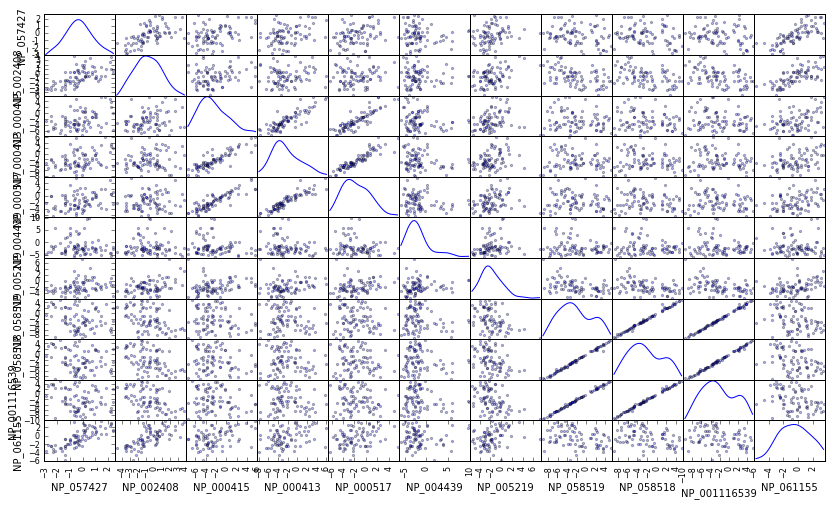

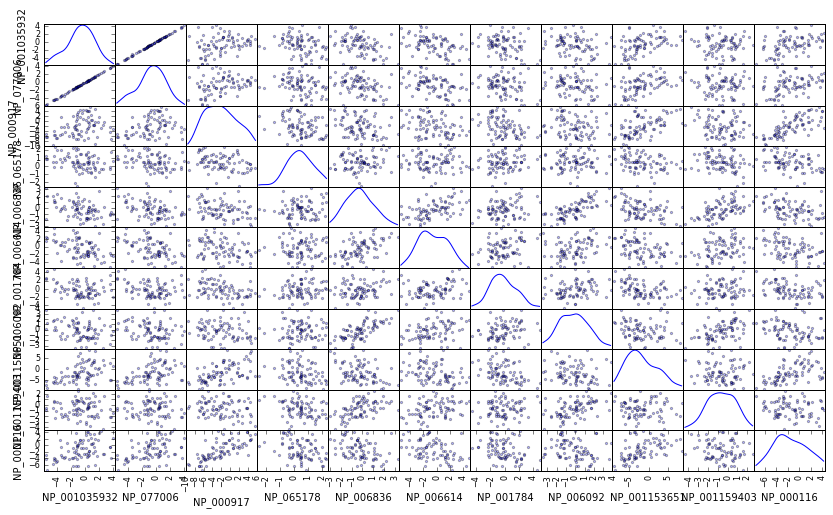

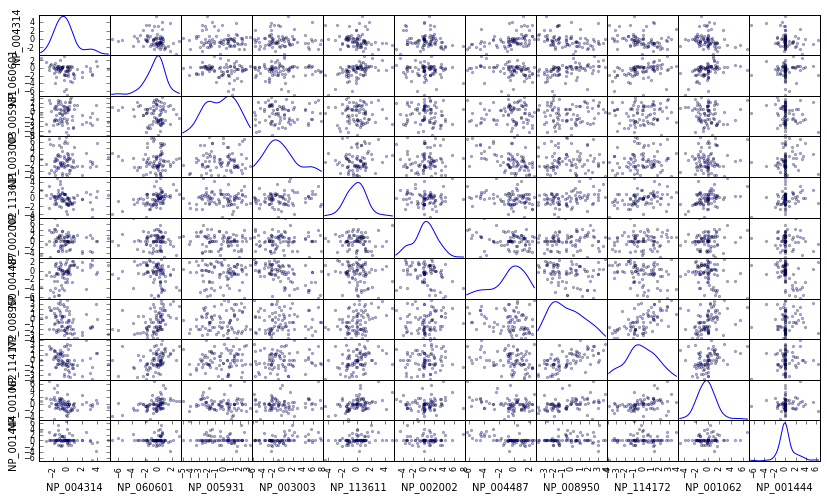

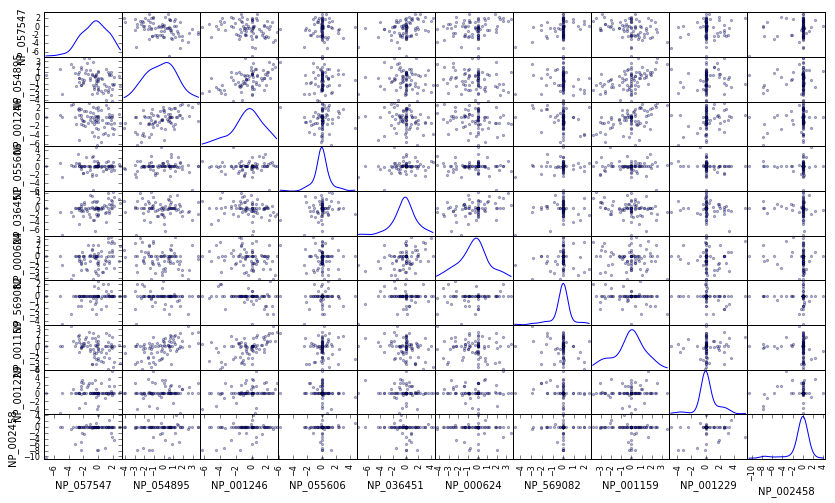

In [10]:
# Preprocess feature columns
def preprocess_features(X):
    columns = list(X.columns)
    X[columns] = X[columns].fillna(0)
    return X

preprocess_data = preprocess_features(processed_numerical_p50)
#print (preprocess_data.head(10))
preprocess_data_float = preprocess_data.astype(float) # to convert object to float
columns_list = list(preprocess_data_float.columns)
#print (preprocess_data_float[0:5].head(10))
#print (preprocess_data_1.dtypes)
#print (preprocess_data_2.dtypes)

pd.scatter_matrix(preprocess_data_float[columns_list[:11]], alpha = 0.3, figsize = (14,8), diagonal = 'kde');
pd.scatter_matrix(preprocess_data_float[columns_list[11:22]], alpha = 0.3, figsize = (14,8), diagonal = 'kde');
pd.scatter_matrix(preprocess_data_float[columns_list[22:33]], alpha = 0.3, figsize = (14,8), diagonal = 'kde');
pd.scatter_matrix(preprocess_data_float[columns_list[33:43]], alpha = 0.3, figsize = (14,8), diagonal = 'kde');